# Linear Regression

**Author: [Kevin Broløs](https://abzu.ai/team)**

The simplest form of regression. It assumes the relation between all parameters to be linear in nature, but is still often used for its simplicity. It gives you coefficients that tell you what the weights are for each feature, and is less prone to overfitting than our other machine learning models if you use a train and test set.

In [1]:
from sklearn.datasets import load_diabetes
from IPython.display import display, clear_output
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Diabetes dataset

Ten baseline variables: age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**
* Number of Instances: 442
* Number of Attributes: First 10 columns are numeric predictive values
* Target: Column 11 is a quantitative measure of disease progression one year after baseline

Each of the 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL: https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html For more information see: Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499. (https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf)

In [2]:
diabetes = load_diabetes()

In [3]:
data, feature_names = diabetes.data, diabetes.feature_names
target = diabetes.target

We'll reuse most of the pairplot code from last time, but adjust it to respond to the target intensity instead of classes

In [4]:
def pairplot(data, feature_names):
    """
        data: a numpy array with the data
        feature_names: an array of the feature names for labelling
    """
    # Get the amount of features
    features = data.shape[1]
    
    # Get all the combinations of our features
    feature_combinations = [(f1, f2) for f1 in range(features) for f2 in range(features)]
    
    # Create a subplot with 1 row and as many columns as we have comparisons
    fig, axes = plt.subplots(nrows=features, ncols=features, figsize=(20,15))

    # Go through all the combinations and plot the two features against each other in one of the subplots
    for i, feature in enumerate(feature_combinations):
        # expand the (x, y) tuple to an x, y variable
        x, y = feature

        # Create a scatter plot in the i-th subplot (But scatter so the x axis follows columns and y axis rows)
        scatter = axes[y, x].scatter(data[:, x], data[:, y], c=target)
        
        # Set the labels on the x and y axis but only the first y-axes and last x-axes
        if y == features - 1:
            axes[y, x].set(xlabel=feature_names[x])
        if x == 0:
            axes[y, x].set(ylabel=feature_names[y])

    
    # Add a legend for the colored dots
    fig.colorbar(scatter, ax=axes)

    plt.show()

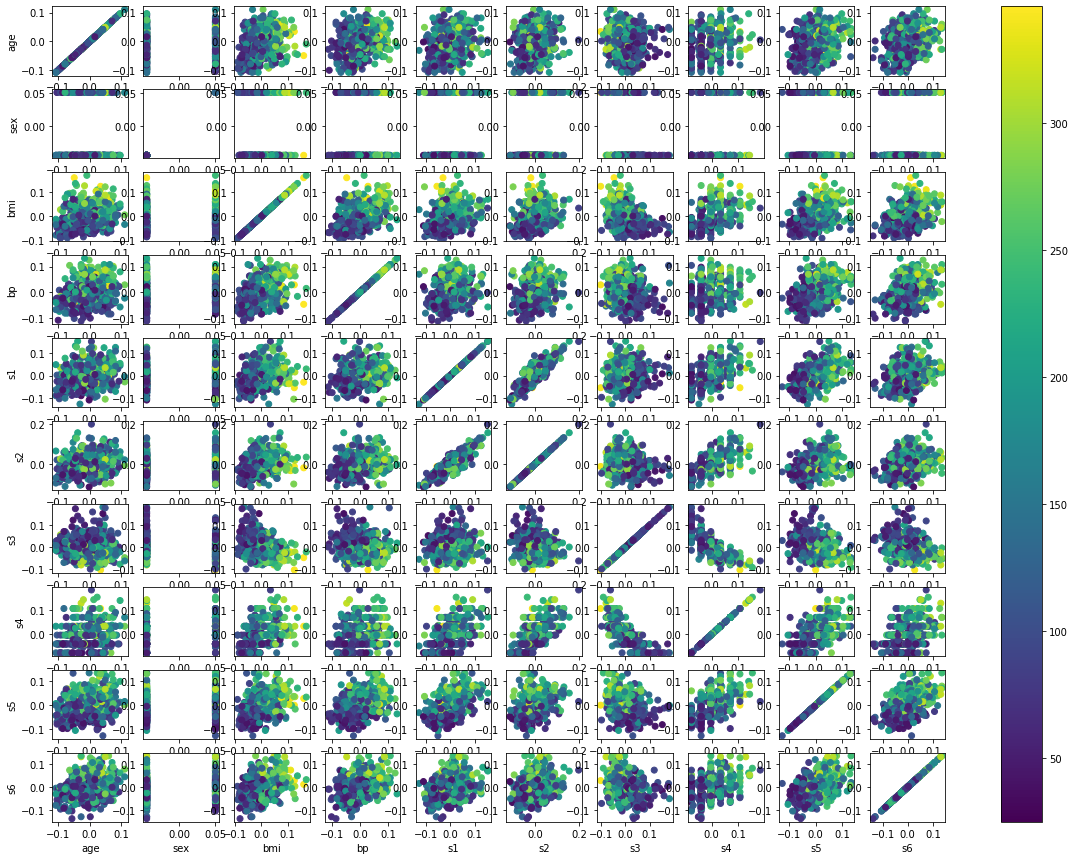

In [5]:
pairplot(data, feature_names)

From this, s1 seems highly correlated with s2 and it normally would probably not make sense to train on both. There's a slight correlation between s2 and s4 to keep in mind.

We can also immediate see that sex is a binary variable for this dataset.

More interestingly for out problem, looking at the point distributions it does appear that we can define somewhat useful linear relationships among features to explain the target variable. I base this off the color gradients being smooth in, for instance, the BMI column and the BP column. It's also somewhat defined for the extremes in most the s columns, but less so.

For more introduction on what to read from this, see [/Guides/01_Data_Analysis](Guides/01_Data_Analysis.ipynb)

# Train/test split

Let's do the usual train/test split

For more introduction on dataset splitting, see [/Guides/05_Holdout_Validation](Guides/05_Holdout_Validation.ipynb)

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, target)

# Fitting a linear regression

A linear regression is a closed-form optimization problem between variables, and there are thus no hyperparameters to tweak. It works by solving an ordinary least squares problem, typically using matrix multiplication.

It's very easy to implement on your own

In [7]:
from numpy.linalg import inv
from numpy import matmul

def fit(X, y):
    X = add_intercept(X)
    first_term = inv(matmul(X.T, X))
    second_term = matmul(X.T, y)

    coef = matmul(first_term, second_term)
    return coef

def add_intercept(X):
    ones = np.ones((X.shape[0], 1))
    return np.concatenate((ones, X), axis=1)

def predict(X, coef):
    X = add_intercept(X)
    return matmul(X, coef)

# Start by fitting on just one feature

Since linear regressions are easier to understand with one feature, we'll start with one

### Mini exercise:
Try to change the feature_no to see how it fits different features

In [8]:
feature_no = 2
x = X_train[:, np.newaxis, feature_no]
x_t = X_test[:, np.newaxis, feature_no]

In [9]:
coef = fit(x, y_train)
coef

array([151.28980467, 968.94286093])

# Evaluating the model

We can of course evaluate the linear fit by plotting it, as well as using some measures of deviation, like the RMSE (Root Mean Squared Error, or the root of mean squared deviation)

In [10]:
def RMSE(y_pred, y_true):
    return np.sqrt(np.mean((y_pred - y_true)**2))

def plot_regression(x, y_pred, y_true, feature_name):
    fig = plt.figure(figsize=(10, 5))
    
    sorted_indices = np.argsort(x[:,0])
    plt.scatter(x[sorted_indices], y_true[sorted_indices])
    plt.plot(x[sorted_indices], y_pred[sorted_indices], color='orange')
    plt.xlabel(feature_name)
    
    plt.tight_layout()
    plt.show()

## Get the mean error

We predict and calculate on our test set

In [11]:
# Use the coefficient for predicting
y_pred = predict(x_t, coef)

In [12]:
RMSE(y_pred, y_test)

69.29537615681357

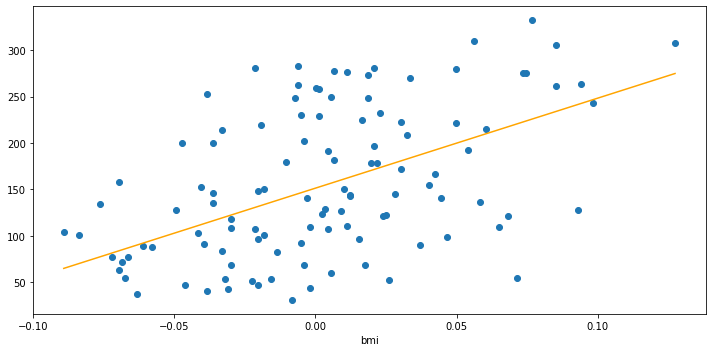

In [13]:
plot_regression(x_t, y_pred, y_test, feature_names[feature_no])

# Using Sklearn
of course scikit learn also has you covered, and allows for a bit more flexibility than the one we just made

In [14]:
LR = LinearRegression()
LR.fit(x, y_train)

# You'll see the coefficients are the same as above
print(LR.intercept_, LR.coef_)

151.2898046658824 [968.94286093]


In [15]:
y_pred = LR.predict(x_t)

Test RMSE: 69.29537615681357


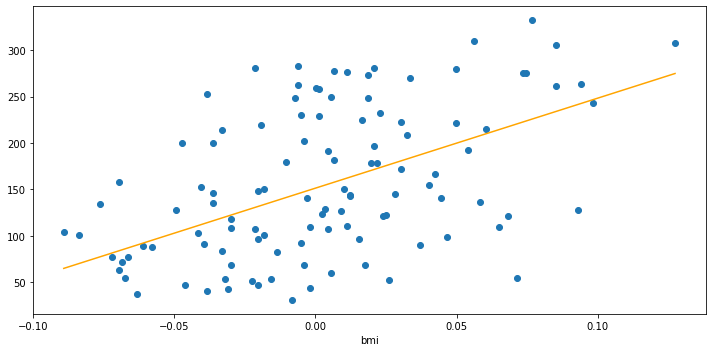

In [16]:
print("Test RMSE:", RMSE(y_pred, y_test))

plot_regression(x_t, y_pred, y_test, feature_names[feature_no])

# Adding more features

As we add more features, it becomes harder to visualize, so we can either display the linear prediction across all features, or show a plot for each feature.

In [17]:
def plot_target_match(y_pred, y_true, title=None):
    sorted_indices = np.argsort(y_true)
    x = np.arange(len(y_true))
    plt.scatter(x, y_true[sorted_indices])
    plt.plot(x, y_pred[sorted_indices], color='orange')
    plt.title(title)

In [18]:
def plot_multi_regression(x, y_pred, y_true, feature_names):
    n_plots = x.shape[1]
    cols = 2
    n_rows = int(np.ceil(n_plots / 2))
    
    fig, axes = plt.subplots(nrows=n_rows, ncols = cols, figsize=(15, 15))
    
    for i in range(x.shape[1]):
        row = int(i/cols)
        col = i%cols
        
        sorted_indices = np.argsort(x[:,i])
        axes[row, col].scatter(x[sorted_indices, i], y_true[sorted_indices])
        axes[row, col].plot(x[sorted_indices, i], y_pred[sorted_indices], color='orange')
        axes[row, col].set(xlabel=feature_names[i])
    
    plt.tight_layout()
    plt.show()

In [19]:
LR = LinearRegression()
LR.fit(X_train, y_train)

LR.coef_

array([ -41.01674801, -233.03794253,  589.84049339,  350.81142471,
       -861.92079056,  529.89976496,  123.66180356,  171.86139556,
        726.36222735,   35.28722991])

## Looking at the coefficients

It seems the coefficients support our theory from the pairplot somewhat, in that the high coefficients are found among the features with the smoothest gradients.

Higher absolute coefficients means more impactful feature, in either the positive or negative direction of the target variable

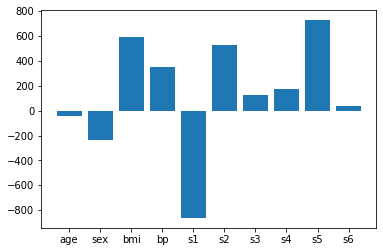

In [20]:
plt.bar(feature_names, LR.coef_)
plt.show()

## Evaluating

Let's see how it fits the target variable

In [21]:
# Get prediction on the test set
y_pred = LR.predict(X_test)

RMSE Test 58.798512192284065


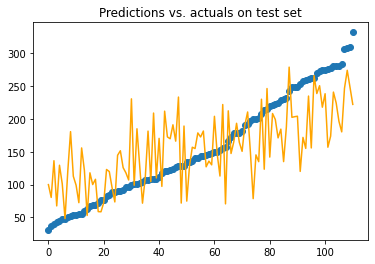

In [22]:
print("RMSE Test", RMSE(y_pred, y_test))
plot_target_match(y_pred, y_test, "Predictions vs. actuals on test set")

Let's see how it behaves among all the features

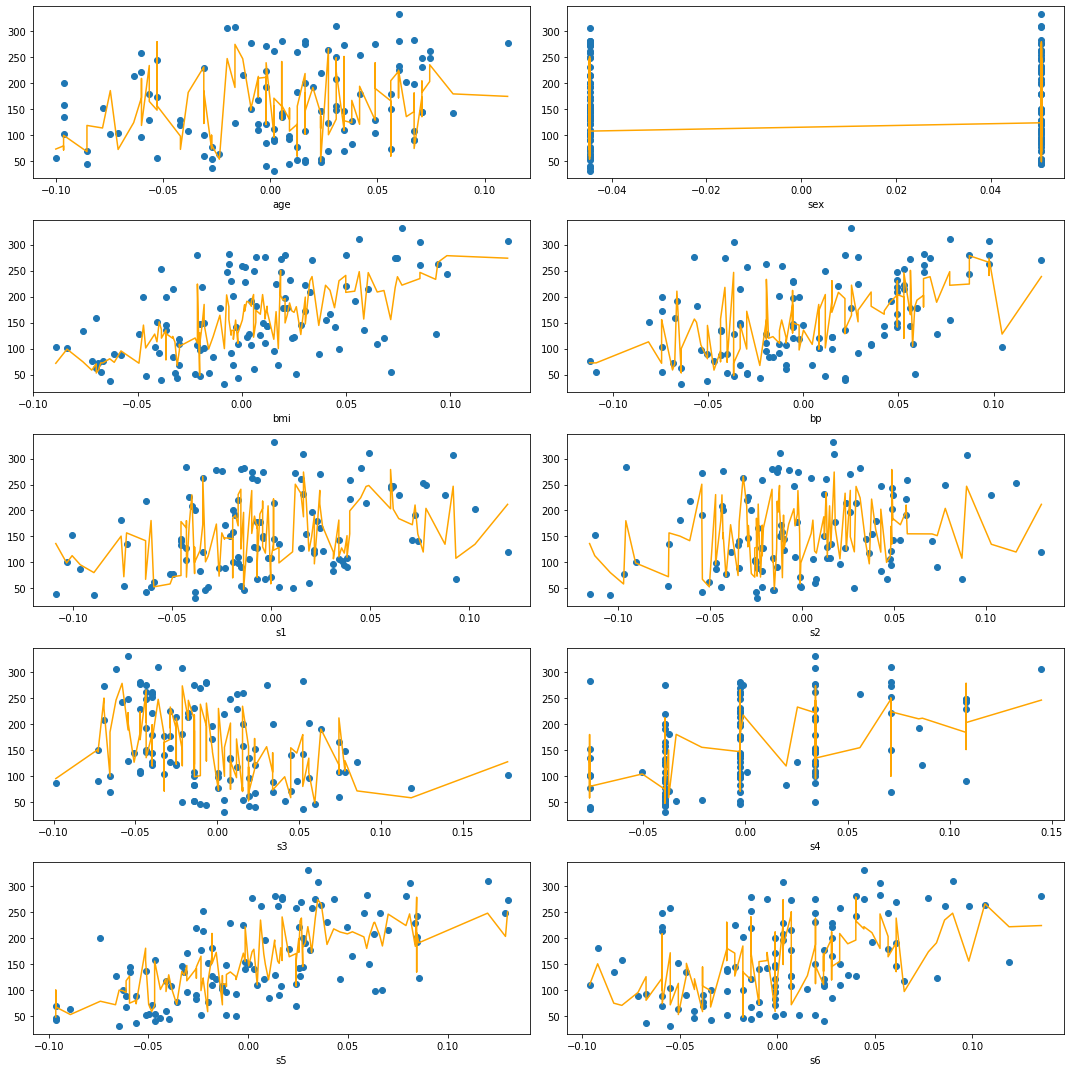

In [23]:
plot_multi_regression(X_test, y_pred, y_test, feature_names)